2DOF :  2 angles
Circular obstacles that it cannot bump into
1. Calculate config space for these two robots 
2. Make arms rectangular 
3. You can decide length and width of arms
4. 3 spheres obstacles -> you decide diameter and location
5. Calculate configuration space by randomly sampling and see if it collides
    1. Sample every combination 
    2. Get an image  - > (workspace, config_space)
6.  Train from work space to estimate config space
    1. See if shape 


In [1]:
import math
from shapely.geometry import Polygon,Point,LineString,MultiPoint
from shapely import affinity
import matplotlib.pyplot as plt

In [2]:
def round_line_string(ls):
    linestring = []
    for point in ls.boundary.geoms:
        linestring.append(Point(round(point.x,4),round(point.y,4)))
    return LineString(linestring)

def calculate_cobs_iter(arm_1,total_arm,q_1,q_2,obst):
    rf_pt = robot_arm1.boundary.geoms[0]
    c_obs_pts = []
    for i in q_1:
        arm_1_rotated = round_line_string(affinity.rotate(arm_1,i,rf_pt))
        total_arm_rotated = round_line_string(affinity.rotate(total_arm,i,rf_pt))
        arm_2 = round_line_string(LineString([arm_1_rotated.boundary.geoms[1],total_arm_rotated.boundary.geoms[1]]))
        arm_2_rf_pt = arm_2.boundary.geoms[0]
        for j in q_2:
        # for j in range(q_2[0],q_2[1],-1):
            arm_2_rotated = round_line_string(affinity.rotate(arm_2,j,arm_2_rf_pt))
            if type(arm_2_rotated.intersection(arm_1_rotated)) != Point:
                c_obs_pts.append((i,abs(j)))
                break
            for o in obst:
                if arm_2_rotated.intersects(o) or arm_1_rotated.intersects(o):
                    c_obs_pts.append((i,abs(j)))
                    break
    return c_obs_pts

def calculate_cobs(arm_1,total_arm,q_1,q_2,obst):
    rf_pt = robot_arm1.boundary.geoms[0]
    c_obs_pts = []
    for i in range(q_1[0],q_1[1]+1):
        arm_1_rotated = round_line_string(affinity.rotate(arm_1,i,rf_pt))
        total_arm_rotated = round_line_string(affinity.rotate(total_arm,i,rf_pt))
        arm_2 = round_line_string(LineString([arm_1_rotated.boundary.geoms[1],total_arm_rotated.boundary.geoms[1]]))
        arm_2_rf_pt = arm_2.boundary.geoms[0]
        for j in range(q_2[0],q_2[1]-1,-1):
            arm_2_rotated = round_line_string(affinity.rotate(arm_2,j,arm_2_rf_pt))
            if type(arm_2_rotated.intersection(arm_1_rotated)) != Point:
                c_obs_pts.append((i,abs(j)))
                break
            for o in obst:
                if arm_2_rotated.intersects(o) or arm_1_rotated.intersects(o):
                    c_obs_pts.append((i,abs(j)))
                    break
    return c_obs_pts


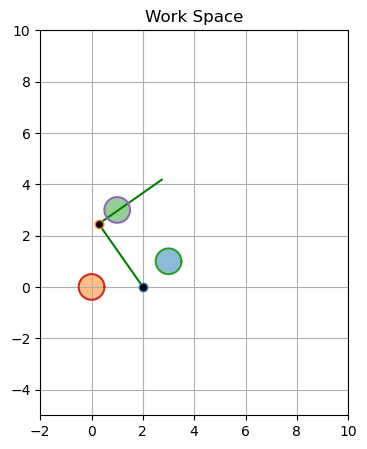

In [3]:
import math
from shapely.geometry import LineString,MultiPoint,Point
import matplotlib.pyplot as plt
from shapely import affinity

# two functions for plotting
def plot_coords(coords):
    pts = list(coords)
    x, y = zip(*pts)
    plt.plot(x,y)

def plot_polys(polys):
    for poly in polys:
        plot_coords(poly.exterior.coords)
        plt.fill_between(*poly.exterior.xy, alpha=.5)

robot_arm1_og = LineString([Point(2,0),Point(5,0)])
total_arm_og = LineString([Point(2,0),Point(8,0)])

robot_arm1 = round_line_string(affinity.rotate(robot_arm1_og,125,robot_arm1_og.boundary.geoms[0]))
total_arm = round_line_string(affinity.rotate(total_arm_og,125,total_arm_og.boundary.geoms[0]))

robot_arm2 = round_line_string(LineString([robot_arm1.boundary.geoms[1],total_arm.boundary.geoms[1]]))
robot_arm2 = round_line_string(affinity.rotate(robot_arm2,-90,robot_arm2.boundary.geoms[0]))


fig,ax = plt.subplots(figsize=(5,5))
ax.plot(*robot_arm1.xy,color='green')
ax.plot(*robot_arm2.xy,color='green')
ax.plot(*robot_arm1.boundary.geoms[0].xy,marker="o",markerfacecolor="black")
ax.plot(*robot_arm2.boundary.geoms[0].xy,marker="o",markerfacecolor="black")

obst_1 = Point(3,1).buffer(.5)
obst_2 = Point(0,0).buffer(.5)
obst_3 = Point(1,3).buffer(.5)

obstacles = [obst_1,obst_2,obst_3]

ax.set_title("Work Space")
ax.set_xlim([-2,10])
ax.set_ylim([-5,10])
ax.set_aspect( 1 )
plot_polys(obstacles)
plt.grid()

In [4]:
c_obs_pts = calculate_cobs_iter(robot_arm1_og,total_arm_og,[0,45,90,120],[0,-25,-45,-90],obstacles)
print(c_obs_pts)

[(45, 0), (45, 25), (45, 45), (45, 90), (120, 45), (120, 90)]


In [5]:
import math
from shapely.geometry import LineString,MultiPoint,Point
import matplotlib.pyplot as plt
from shapely import affinity

# two functions for plotting
def plot_coords(ax,coords):
    pts = list(coords)
    x, y = zip(*pts)
    ax.plot(x,y,color='red')

def plot_polys(ax,polys):
    for poly in polys:
        plot_coords(ax,poly.exterior.coords)
        ax.fill_between(*poly.exterior.xy, alpha=.5)

def plot_work_space_with_detected_collision_pts(robot_arm1_og,total_arm_og,obstacles,detected_collision_pts):
    fig,axs = plt.subplots(3,2,figsize=(10,15))
    fig.suptitle("Work space with detected collisions", fontsize=14)
    count = 0
    for i in range(3):
        for j in range(2):
            arm_1_rot,arm_2_rot = detected_collision_pts[count]
            count += 1
            robot_arm1 = round_line_string(affinity.rotate(robot_arm1_og,arm_1_rot,robot_arm1_og.boundary.geoms[0]))
            total_arm = round_line_string(affinity.rotate(total_arm_og,arm_1_rot,total_arm_og.boundary.geoms[0]))

            robot_arm2 = round_line_string(LineString([robot_arm1.boundary.geoms[1],total_arm.boundary.geoms[1]]))
            robot_arm2 = round_line_string(affinity.rotate(robot_arm2,-arm_2_rot,robot_arm2.boundary.geoms[0]))

            axs[i,j].plot(*robot_arm1.xy,color='green')
            axs[i,j].plot(*robot_arm2.xy,color='green')
            axs[i,j].plot(*robot_arm1.boundary.geoms[0].xy,marker="o",markerfacecolor="black")
            axs[i,j].plot(*robot_arm2.boundary.geoms[0].xy,marker="o",markerfacecolor="black")
            axs[i,j].set_title(f"Collision at ({arm_1_rot},{arm_2_rot})")
            plot_polys(axs[i,j],obstacles)

            axs[i,j].set_xlim([-2,10])
            axs[i,j].set_ylim([-5,10])
            axs[i,j].grid()

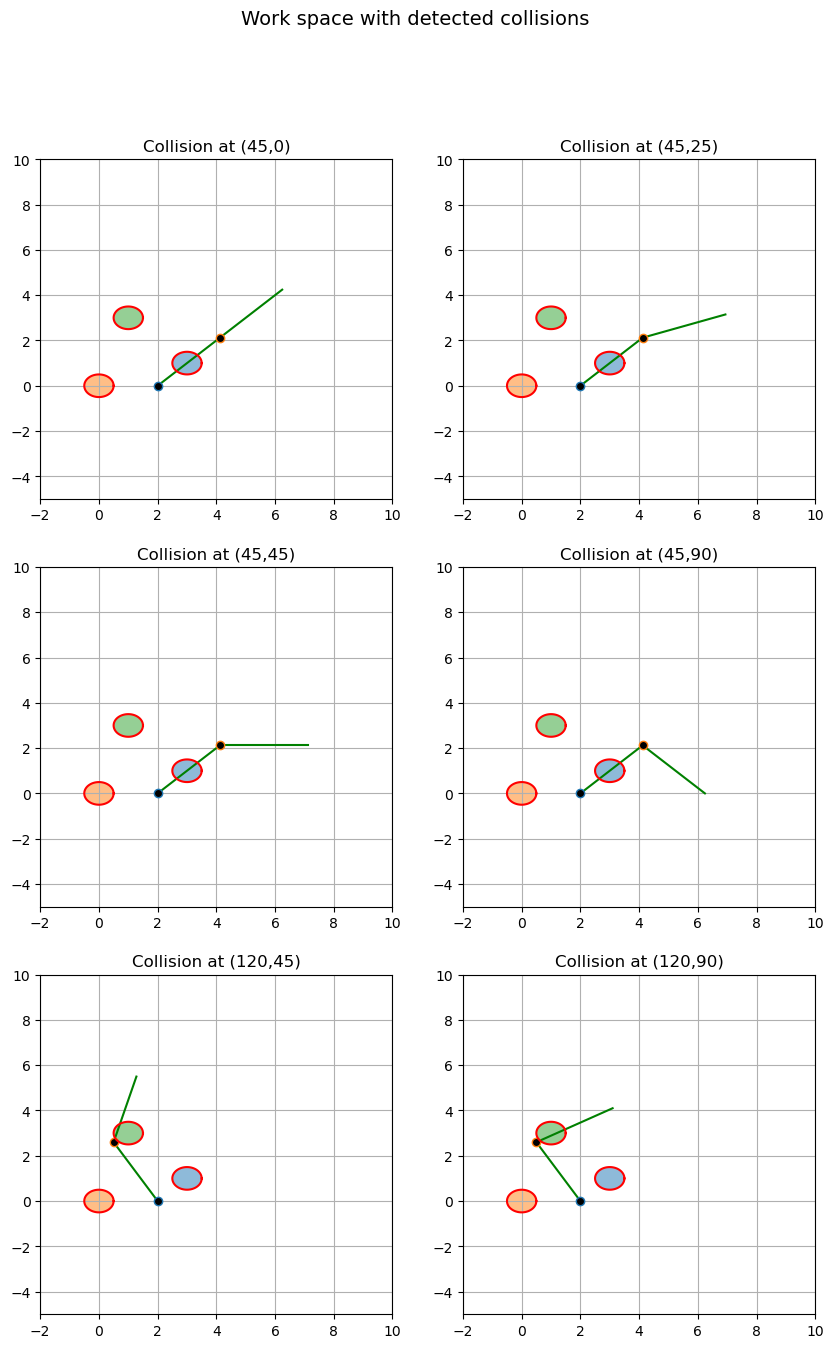

In [6]:
plot_work_space_with_detected_collision_pts(robot_arm1_og,total_arm_og,obstacles,c_obs_pts)

In [7]:
c_obs = calculate_cobs(robot_arm1_og,total_arm_og,[0,359],[0,-180],obstacles)

In [8]:
print(len(c_obs))

21371


[]

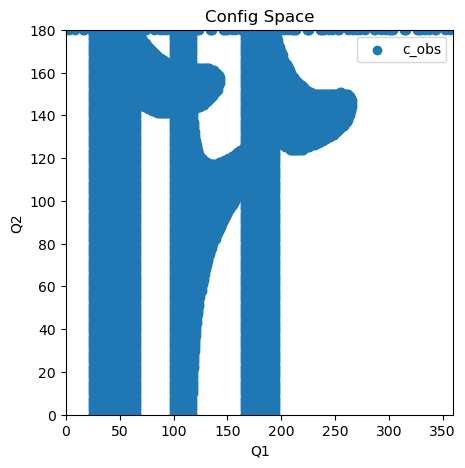

In [9]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(5,5))
ax.set_title("Config Space")
ax.set_xlim([0,360])
ax.set_ylim([0,180])
ax.set_xlabel('Q1')
ax.set_ylabel('Q2')
x_s = list(map(lambda pt: pt[0],c_obs))
y_s = list(map(lambda pt: pt[1],c_obs))
ax.scatter(x_s,y_s,label='c_obs')
ax.legend()
plt.plot()